# Sales Demand Forescasting

### Contexto

Este projeto tem como alvo principal o desenvolvimento de um modelo geral de gerenciamento de inventário e forecasting de demanda, a partir da perspectiva de uma janela com múltiplas lojas e produtos de uma grande rede.

Dentre os objetivos, devemos:
- Realizar uma análise criteriosa sobre as informações de vendas, fornecendo um feedback sobre performance de produtos, lojas, e montando um plano de ação de acordo com as necessidades atuais de cada loja para seus respectivos produtos.
- Montar um modelo de previsão que possa ser modular e com grande precisão dentro das métricas mais comuns da área de S&OP, obtendo o menor custo possível dentro da visão de custos de posse e vendas perdidas por falta de estoque.
- Realizar revisões periódicas sobre as semanas, montando um sistema que garanta um índice de safety stock e que esteja dentro do leadtime previsto.

Algumas premissas:
- Os dados brutos estão granulares (previstos em dias), mas a previsão irá ser feita em semanas.
- O leadtime para cada entrega é de 1 semana, e os pedidos são feitos às sextas (inventário no final da semana), mas chegam apenas na segunda-feira da segunda semana  (ou 10 dias após o pedido), e nesses dias são feitas a contagem do inventário inicial.
- Não há limite de pedidos, e as entregas são feitas sem atrasos.

A avaliação do modelo será feita baseada nas métricas mais populares do mercado:
- Root Mean Squared Error
- Mean Absolute Error
- Weighted Mean Absolute Error

Mas também teremos um olhar, caso necessário, para avaliações de produtos e dias com vendas zero, com base em métricas como o MASE (Mean Absolute Scaled Error).

Os custos serão fixados em:
Falta de estoque: R$2
Posse: R$0,50

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm

In [34]:
## importando a base de dados

## Vamos fazer a importação da base de dados em 3 etapas
## A base inicial é a vinda da fonte online
## Nas outras 2, usamos uma base ampliada e sintética, mas baseada na original

# base_df = pd.read_csv('./Bases/retail_store_inventory_opendata.csv', parse_dates=['Date'])
base_df = pd.read_csv('./Bases/retail_store_inventory_expanded.csv', parse_dates=['Date'])
# base_df = pd.read_csv("./Bases/synthetic_inventory_dataset.csv", parse_dates=['Date'])
base_df.head(5)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Electronics,North,243,81,201,3.08,48.26,10,Cloudy,1,49.90,Spring
1,2022-01-01,S001,P0002,Toys,South,227,177,119,74.20,90.51,9,Cloudy,1,60.70,Spring
2,2022-01-01,S001,P0003,Electronics,East,135,143,115,16.50,15.54,9,Cloudy,1,92.88,Spring
3,2022-01-01,S001,P0004,Toys,North,282,96,158,24.38,80.16,5,Cloudy,1,27.19,Spring
4,2022-01-01,S001,P0005,Toys,West,318,124,63,32.81,88.89,10,Cloudy,1,49.06,Spring


In [35]:
## Cada infor conterá as informações primordias da base de dados
## Futuramente, voltaremos a usar essa função para cada nova base derivada

base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822375 entries, 0 to 822374
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                822375 non-null  datetime64[ns]
 1   Store ID            822375 non-null  object        
 2   Product ID          822375 non-null  object        
 3   Category            822375 non-null  object        
 4   Region              822375 non-null  object        
 5   Inventory Level     822375 non-null  int64         
 6   Units Sold          822375 non-null  int64         
 7   Units Ordered       822375 non-null  int64         
 8   Demand Forecast     822375 non-null  float64       
 9   Price               822375 non-null  float64       
 10  Discount            822375 non-null  int64         
 11  Weather Condition   822375 non-null  object        
 12  Holiday/Promotion   822375 non-null  int64         
 13  Competitor Pricing  822375 no

In [36]:
## O describe vai fornecer uma visão crua de como estão as variáveis numéricas da base

base_df.describe()

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,822375,822375.000000,822375.000000,822375.000000,822375.000000,822375.000000,822375.000000,822375.000000,822375.000000
mean,2022-12-31 23:59:59.999999232,274.197079,133.785092,109.554051,142.023050,55.118553,9.431319,0.441860,55.131236
min,2022-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,1.260000,0.000000,0.000000,0.000000
25%,2022-07-02 00:00:00,162.000000,46.000000,64.000000,54.000000,32.700000,4.000000,0.000000,32.650000
50%,2023-01-01 00:00:00,274.000000,105.000000,109.000000,113.850000,54.990000,9.000000,0.000000,55.040000
75%,2023-07-03 00:00:00,387.000000,200.000000,155.000000,209.090000,77.750000,15.000000,1.000000,77.830000
max,2024-01-01 00:00:00,545.000000,525.000000,218.000000,544.190000,110.090000,23.000000,1.000000,111.380000
std,NaN,130.613538,109.658209,52.541573,109.779967,26.126756,7.015773,0.496609,26.335014


In [37]:
## Separando em 2 arquivos para melhor visualização sobre vendas e estoque

stock_df = base_df.copy()[[
    'Date',
    'Store ID',
    'Product ID',
    'Category',
    'Region',
    'Inventory Level',
    'Units Ordered',
    'Units Sold',
    'Demand Forecast',
    'Holiday/Promotion'
]]

## fornecendo uma visão sobre vendas perdidas, inventário final e estoque em trânsito
stock_df['Missed Sales'] = (stock_df['Demand Forecast'] - stock_df['Inventory Level']).clip(lower=0)
# End Inventory = max(Inventory Level - Units Sold, 0)
stock_df['End Inventory'] = (stock_df['Inventory Level'] - stock_df['Units Sold']).clip(lower=0)
stock_df['Stock In Transit'] = 0

## montando a visão de custos
stock_df['Holding Cost'] = stock_df['Inventory Level'] * 0.5
stock_df['Shortage Cost'] = stock_df['Missed Sales'] * 2.0
stock_df['Total Cost'] = stock_df['Holding Cost'] + stock_df['Shortage Cost']

stock_df[(stock_df['Store ID'] == 'S001') & (stock_df['Product ID'] == 'P0001') & (stock_df['Category'] == 'Electronics') & (stock_df['Region'] == 'North')].head(10)
# stock_df.head(5)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Ordered,Units Sold,Demand Forecast,Holiday/Promotion,Missed Sales,End Inventory,Stock In Transit,Holding Cost,Shortage Cost,Total Cost
0,2022-01-01,S001,P0001,Electronics,North,243,201,81,3.08,1,0.00,162,0,121.5,0.00,121.50
36000,2022-02-02,S001,P0001,Electronics,North,449,172,67,60.63,1,0.00,382,0,224.5,0.00,224.50
51750,2022-02-16,S001,P0001,Electronics,North,74,29,43,201.52,0,127.52,31,0,37.0,255.04,292.04
91125,2022-03-23,S001,P0001,Electronics,North,175,152,209,17.28,1,0.00,0,0,87.5,0.00,87.50
136125,2022-05-02,S001,P0001,Electronics,North,120,91,0,16.45,1,0.00,120,0,60.0,0.00,60.00
156375,2022-05-20,S001,P0001,Electronics,North,62,26,149,138.51,0,76.51,0,0,31.0,153.02,184.02
182250,2022-06-12,S001,P0001,Electronics,North,210,152,105,209.38,0,0.00,105,0,105.0,0.00,105.00
199125,2022-06-27,S001,P0001,Electronics,North,351,60,126,72.48,1,0.00,225,0,175.5,0.00,175.50
264375,2022-08-24,S001,P0001,Electronics,North,143,95,65,311.86,1,168.86,78,0,71.5,337.72,409.22
298125,2022-09-23,S001,P0001,Electronics,North,117,117,17,86.03,1,0.00,100,0,58.5,0.00,58.50


In [38]:
## Para os dados de estoque, vamos agregar semanalmente os dados diários
## Iremos incluir algumas colunas importantes para futuras análises, como BIAS, Stock In Transit e Inventory Available

weekly_stock_df = (
    stock_df
    .groupby(
        ['Store ID', 'Product ID', 'Category', 'Region', 'Holiday/Promotion', pd.Grouper(key='Date', freq='W-MON')],
        as_index=False
    )
    .agg(
        UnitsSold=('Units Sold', 'sum'),        
        DemandForecast=('Demand Forecast', 'sum'),
        InventoryLevel=('Inventory Level', 'sum'),
        UnitsOrdered=('Units Ordered', 'sum'),
        MissedSales=('Missed Sales', 'sum'),
        EndInventory=('End Inventory', 'last'),
        StockInTransit=('Stock In Transit', 'sum'),
        HoldingCost=('Holding Cost', 'sum'),
        ShortageCost=('Shortage Cost', 'sum'),
        TotalCost=('Total Cost', 'sum')

    )
    .sort_values(['Store ID', 'Product ID', 'Date'])
    .reset_index(drop=True)
)

## gerando o BIAS para melhorar o entendimento dos dados
weekly_stock_df['BIAS'] = weekly_stock_df['DemandForecast'] - weekly_stock_df['UnitsSold']

# Alinhando o dataframe para receber os dados de stock em trânsito
weekly_stock_df = weekly_stock_df.sort_values(['Store ID', 'Product ID', 'Date']).reset_index(drop=True)

GROUP_COLS = ['Store ID', 'Product ID']
LEAD_TIME_WEEKS = 2

# 1. Trazer o 'Units Ordered' do período de Lead Time atrás (LT=2 semanas)
# O pedido feito em t-2 é o que está em trânsito e chegará na semana t.
# Aqui, usaremos a coluna UnitsOrdered

weekly_stock_df['StockInTransit'] = (
    weekly_stock_df.groupby(GROUP_COLS)['UnitsOrdered']
    .shift(LEAD_TIME_WEEKS)
    .fillna(0)
    .astype(int)
)

# 2. Calcular o Estoque Disponível (Inventory Available - IA)
# O IA é a métrica S&OP crucial que combina estoque e o que está a caminho.
# IA(t) = Estoque Atual + Estoque em Trânsito (SIT)

weekly_stock_df['InventoryAvailable'] = (
    weekly_stock_df['EndInventory'] 
    + weekly_stock_df['StockInTransit']
)

## Custos cumulativos
weekly_stock_df['CumulativeHoldingCost'] = weekly_stock_df.groupby(['Store ID', 'Product ID'])['HoldingCost'].cumsum()
weekly_stock_df['CumulativeShortageCost'] = weekly_stock_df.groupby(['Store ID', 'Product ID'])['ShortageCost'].cumsum()
weekly_stock_df['CumulativeTotalCost'] = weekly_stock_df.groupby(['Store ID', 'Product ID'])['TotalCost'].cumsum()

# adicionar identificação explícita da semana:
# weekly_stock_df['WeekStart'] = weekly_stock_df['Date'] - pd.to_timedelta(weekly_stock_df['Date'].dt.weekday, unit='d')
# weekly_stock_df['WeekEnd'] = weekly_stock_df['WeekStart'] + pd.Timedelta(days=6)
# weekly_stock_df['WeekLabel'] = weekly_stock_df['WeekStart'].dt.strftime('%Y-%m-%d')  # rótulo = data de início da semana


print(weekly_stock_df.shape)
weekly_stock_df.head(5)

(761463, 21)


,Store ID,Product ID,Category,Region,Holiday/Promotion,Date,UnitsSold,DemandForecast,InventoryLevel,UnitsOrdered,MissedSales,EndInventory,StockInTransit,HoldingCost,ShortageCost,TotalCost,BIAS,InventoryAvailable,CumulativeHoldingCost,CumulativeShortageCost,CumulativeTotalCost
0,S001,P0001,Electronics,North,1,2022-01-03,81,3.08,243,201,0.00,162,0,121.5,0.00,121.50,-77.92,162,121.5,0.00,121.50
1,S001,P0001,Furniture,North,0,2022-01-03,48,31.49,453,103,0.00,405,0,226.5,0.00,226.50,-16.51,405,348.0,0.00,348.00
2,S001,P0001,Groceries,North,0,2022-01-03,13,145.78,432,183,0.00,419,201,216.0,0.00,216.00,132.78,620,564.0,0.00,564.00
3,S001,P0001,Clothing,South,0,2022-01-10,80,36.65,275,104,0.00,195,103,137.5,0.00,137.50,-43.35,298,701.5,0.00,701.50
4,S001,P0001,Groceries,East,1,2022-01-10,428,216.77,495,125,52.86,111,183,247.5,105.72,353.22,-211.23,294,949.0,105.72,1054.72


In [39]:
# Visualizar o resultado
print("Visualização da Dinâmica de Inventário com Lead Time:")
weekly_stock_df[
    (weekly_stock_df['Store ID'] == 'S001') & (weekly_stock_df['Product ID'] == 'P0001')
].head(7)[['Date', 'UnitsOrdered', 'EndInventory', 'StockInTransit', 'InventoryAvailable']]

Visualização da Dinâmica de Inventário com Lead Time:


,Date,UnitsOrdered,EndInventory,StockInTransit,InventoryAvailable
0,2022-01-03,201,162,0,162
1,2022-01-03,103,405,0,405
2,2022-01-03,183,419,201,620
3,2022-01-10,104,195,103,298
4,2022-01-10,125,111,183,294
5,2022-01-10,171,0,104,104
6,2022-01-10,160,0,125,125


In [40]:
sales_df = base_df.copy()[[
    'Date',
    'Store ID',
    'Product ID',
    'Category',
    'Region',
    'Units Sold',
    'Demand Forecast',
    'Price',
    'Discount',
    'Weather Condition',
    'Holiday/Promotion',
    'Competitor Pricing',
    'Seasonality'
]]

## gerando o BIAS para melhorar o entendimento dos dados
sales_df['BIAS'] = sales_df['Demand Forecast'] - sales_df['Units Sold']

sales_df['Discount_frac'] = np.where(
    sales_df['Discount'] > 1,
    sales_df['Discount'] / 100,
    sales_df['Discount']
)

sales_df['NetRevenue'] = round((
    sales_df['Price'] 
    * (1 - sales_df['Discount_frac']) 
    * sales_df['Units Sold']
    )
, 2)

sales_df.head(5)

,Date,Store ID,Product ID,Category,Region,Units Sold,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,BIAS,Discount_frac,NetRevenue
0,2022-01-01,S001,P0001,Electronics,North,81,3.08,48.26,10,Cloudy,1,49.90,Spring,-77.92,0.10,3518.15
1,2022-01-01,S001,P0002,Toys,South,177,74.20,90.51,9,Cloudy,1,60.70,Spring,-102.80,0.09,14578.45
2,2022-01-01,S001,P0003,Electronics,East,143,16.50,15.54,9,Cloudy,1,92.88,Spring,-126.50,0.09,2022.22
3,2022-01-01,S001,P0004,Toys,North,96,24.38,80.16,5,Cloudy,1,27.19,Spring,-71.62,0.05,7310.59
4,2022-01-01,S001,P0005,Toys,West,124,32.81,88.89,10,Cloudy,1,49.06,Spring,-91.19,0.10,9920.12


In [41]:
weekly_sales_df = (
    sales_df
    .groupby(
        ['Store ID', 'Product ID', 'Category', 'Region', 'Holiday/Promotion', pd.Grouper(key='Date', freq='W-MON')],
        as_index=False
    )
    .agg(
        UnitsSold=('Units Sold', 'sum'),            # unidades por semana
        NetRevenue=('NetRevenue', 'sum'),  # receita líquida por semana
        DemandForecast=('Demand Forecast', 'sum'),

    )
    .sort_values(['Store ID', 'Product ID', 'Date'])
    .reset_index(drop=True)
)

## gerando o BIAS para melhorar o entendimento dos dados
weekly_sales_df['BIAS'] = weekly_sales_df['DemandForecast'] - weekly_sales_df['UnitsSold']

print(weekly_sales_df.shape)
weekly_sales_df.head(5)

(761463, 10)


,Store ID,Product ID,Category,Region,Holiday/Promotion,Date,UnitsSold,NetRevenue,DemandForecast,BIAS
0,S001,P0001,Electronics,North,1,2022-01-03,81,3518.15,3.08,-77.92
1,S001,P0001,Furniture,North,0,2022-01-03,48,3036.48,31.49,-16.51
2,S001,P0001,Groceries,North,0,2022-01-03,13,1184.04,145.78,132.78
3,S001,P0001,Clothing,South,0,2022-01-10,80,4091.14,36.65,-43.35
4,S001,P0001,Groceries,East,1,2022-01-10,428,15649.34,216.77,-211.23


In [42]:
## Salvando arquivos processados para fins de backup e uso futuro
weekly_stock_df.to_csv('./Dados Agrupados/weekly_stock_data.csv', index=False)
weekly_sales_df.to_csv('./Dados Agrupados/weekly_sales_data.csv', index=False)
sales_df.to_csv('./Dados Agrupados/sales_data.csv', index=False)
stock_df.to_csv('./Dados Agrupados/stock_data.csv', index=False) 
initial_state_stock = stock_df.copy()[stock_df['Date'] == stock_df['Date'].max()].to_csv('./Dados Agrupados/initial_state_stock.csv', index=False)
print("Arquivos salvos com sucesso na pasta 'Dados Agrupados'.")

Arquivos salvos com sucesso na pasta 'Dados Agrupados'.


## EDA - Análise Exploratória dos Dados

Agora iremos analisar os datasets que foram gerados acima, para criar estudos sobre cada trecho de código que iremos análisar, nos atendo às características dos dados, e em seguida realizando uma análise bivariada (sobre mais de 1 feature) do modelo de dados

In [43]:
print('Realizando análise descritiva dos dados semanais de vendas:')
weekly_sales_df.info()

Realizando análise descritiva dos dados semanais de vendas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761463 entries, 0 to 761462
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Store ID           761463 non-null  object        
 1   Product ID         761463 non-null  object        
 2   Category           761463 non-null  object        
 3   Region             761463 non-null  object        
 4   Holiday/Promotion  761463 non-null  int64         
 5   Date               761463 non-null  datetime64[ns]
 6   UnitsSold          761463 non-null  int64         
 7   NetRevenue         761463 non-null  float64       
 8   DemandForecast     761463 non-null  float64       
 9   BIAS               761463 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 58.1+ MB


In [44]:
weekly_sales_df.describe()

,Holiday/Promotion,Date,UnitsSold,NetRevenue,DemandForecast,BIAS
count,761463.000000,761463,761463.000000,761463.000000,761463.000000,761463.000000
mean,0.446028,2023-01-03 23:46:59.355372288,144.487014,7098.223979,153.383954,8.896940
min,0.000000,2022-01-03 00:00:00,0.000000,0.000000,0.000000,-1017.690000
25%,0.000000,2022-07-04 00:00:00,49.000000,1731.720000,57.660000,-90.720000
50%,0.000000,2023-01-02 00:00:00,114.000000,4621.640000,122.570000,8.460000
75%,1.000000,2023-07-03 00:00:00,215.000000,10100.010000,224.790000,108.820000
max,1.000000,2024-01-01 00:00:00,1188.000000,79578.630000,1284.460000,1071.460000
std,0.497079,NaN,120.066461,7377.725566,121.024424,161.372939


In [45]:
print('Realizando análise descritiva dos dados semanais de estoque:')
weekly_stock_df.info()

Realizando análise descritiva dos dados semanais de estoque:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761463 entries, 0 to 761462
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Store ID                761463 non-null  object        
 1   Product ID              761463 non-null  object        
 2   Category                761463 non-null  object        
 3   Region                  761463 non-null  object        
 4   Holiday/Promotion       761463 non-null  int64         
 5   Date                    761463 non-null  datetime64[ns]
 6   UnitsSold               761463 non-null  int64         
 7   DemandForecast          761463 non-null  float64       
 8   InventoryLevel          761463 non-null  int64         
 9   UnitsOrdered            761463 non-null  int64         
 10  MissedSales             761463 non-null  float64       
 11  EndInventory            761463

In [46]:
weekly_stock_df.describe()

,Holiday/Promotion,Date,UnitsSold,DemandForecast,InventoryLevel,UnitsOrdered,MissedSales,EndInventory,StockInTransit,HoldingCost,ShortageCost,TotalCost,BIAS,InventoryAvailable,CumulativeHoldingCost,CumulativeShortageCost,CumulativeTotalCost
count,761463.000000,761463,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000,761463.000000
mean,0.446028,2023-01-03 23:46:59.355372288,144.487014,153.383954,296.131031,118.317650,24.650521,161.500476,117.962896,148.065515,49.301041,197.366557,8.896940,279.463372,50180.824020,16716.588602,66897.412622
min,0.000000,2022-01-03 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000,-1017.690000,0.000000,13.000000,0.000000,21.500000
25%,0.000000,2022-07-04 00:00:00,49.000000,57.660000,171.000000,68.000000,0.000000,25.000000,67.000000,85.500000,0.000000,118.500000,-90.720000,158.000000,25178.500000,8213.800000,33532.750000
50%,0.000000,2023-01-02 00:00:00,114.000000,122.570000,289.000000,116.000000,0.000000,142.000000,115.000000,144.500000,0.000000,178.440000,8.460000,263.000000,50127.000000,16560.440000,66837.760000
75%,1.000000,2023-07-03 00:00:00,215.000000,224.790000,407.000000,163.000000,0.000000,270.000000,163.000000,203.500000,0.000000,231.840000,108.820000,392.000000,75218.500000,24939.840000,100282.430000
max,1.000000,2024-01-01 00:00:00,1188.000000,1284.460000,1713.000000,670.000000,691.990000,535.000000,670.000000,856.500000,1383.980000,1565.560000,1071.460000,1056.000000,105960.000000,45276.120000,142959.380000
std,0.497079,NaN,120.066461,121.024424,156.700086,62.763295,61.221068,138.167678,62.996012,78.350043,122.442137,123.716957,161.372939,151.841075,28938.029778,9896.373652,38601.015812


In [47]:
print("Verificando a quantidade de produtos, lojas, regiões e categorias únicas na base de dados:")
print(f"Número de lojas únicas: {base_df['Store ID'].nunique()}")
print(f"Número de produtos únicos: {base_df['Product ID'].nunique()}")
print(f"Número de categorias únicas: {base_df['Category'].nunique()}")
print(f"Número de regiões únicas: {base_df['Region'].nunique()}")

Verificando a quantidade de produtos, lojas, regiões e categorias únicas na base de dados:
Número de lojas únicas: 15
Número de produtos únicos: 75
Número de categorias únicas: 5
Número de regiões únicas: 4


## Análise da Distribuição de Vendas e Estoque

Inicialmente, iremos reagrupar os dados para termos uma visão clara de como as informações se comportam ao longo do tempo, e realizar algumas análises, como:
- Comportamento de vendas
- Rupturas Geradas
- Lojas/Produtos com maior e menor saída (curva ABC/Pareto)
- Distribuição de vendas x rupturas

In [48]:
merged_df = pd.merge(
    weekly_sales_df,
    weekly_stock_df,
    # how='left',
    on=['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Holiday/Promotion'],
    suffixes=('_sales', '_stock')
)

cols_to_drop = [col for col in merged_df.columns if col.endswith('_stock')]
merged_df = merged_df.drop(columns=cols_to_drop)

merged_df = merged_df.rename(
    columns=lambda col: col[:-6] if col.endswith('_sales') else col
)

merged_df['Week'] = merged_df['Date'].dt.isocalendar().week
merged_df['Month'] = merged_df['Date'].dt.month.astype('Int64')
merged_df['Year'] = merged_df['Date'].dt.year.astype('Int64')
merged_df['WeekYear'] = (
    merged_df['Date'].dt.isocalendar().week.astype(str)
    + '/'
    + merged_df['Date'].dt.year.astype(str)
)
merged_df['MonthYear'] = (
    merged_df['Date'].dt.month.astype(str)
    + '/'
    + merged_df['Date'].dt.year.astype(str)
)

pd.set_option('display.max_columns', None)
merged_df = merged_df[merged_df['Date'] >= '2022-01-10']
merged_df.head(5)

,Store ID,Product ID,Category,Region,Holiday/Promotion,Date,UnitsSold,NetRevenue,DemandForecast,BIAS,InventoryLevel,UnitsOrdered,MissedSales,EndInventory,StockInTransit,HoldingCost,ShortageCost,TotalCost,InventoryAvailable,CumulativeHoldingCost,CumulativeShortageCost,CumulativeTotalCost,Week,Month,Year,WeekYear,MonthYear
3,S001,P0001,Clothing,South,0,2022-01-10,80,4091.14,36.65,-43.35,275,104,0.00,195,103,137.5,0.00,137.50,298,701.5,0.00,701.50,2,1,2022,2/2022,1/2022
4,S001,P0001,Groceries,East,1,2022-01-10,428,15649.34,216.77,-211.23,495,125,52.86,111,183,247.5,105.72,353.22,294,949.0,105.72,1054.72,2,1,2022,2/2022,1/2022
5,S001,P0001,Groceries,North,0,2022-01-10,344,22818.90,157.01,-186.99,39,171,118.01,0,104,19.5,236.02,255.52,104,968.5,341.74,1310.24,2,1,2022,2/2022,1/2022
6,S001,P0001,Toys,East,1,2022-01-10,375,5511.67,179.25,-195.75,330,160,0.00,0,125,165.0,0.00,165.00,125,1133.5,341.74,1475.24,2,1,2022,2/2022,1/2022
7,S001,P0001,Toys,West,0,2022-01-10,47,3300.08,103.64,56.64,432,80,0.00,385,171,216.0,0.00,216.00,556,1349.5,341.74,1691.24,2,1,2022,2/2022,1/2022


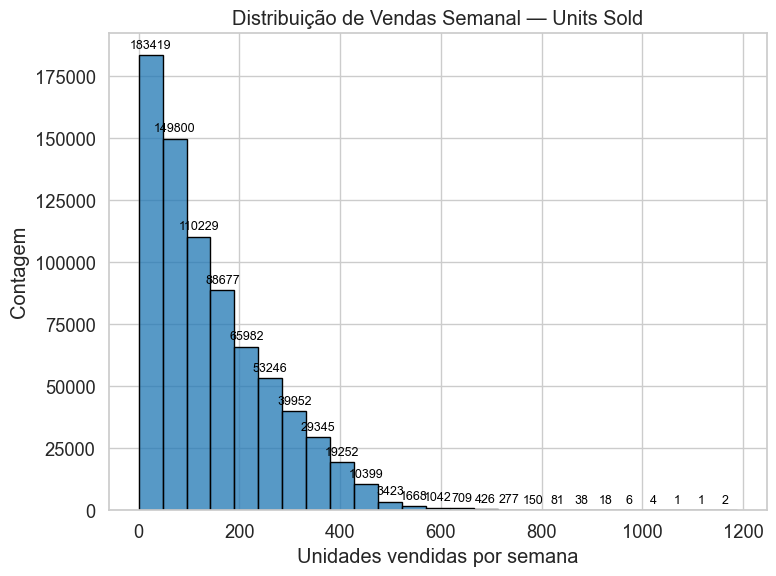

In [49]:
plt.figure(figsize=(8,6))
# usar seaborn para histograma e matplotlib para anotações
ax = sns.histplot(
    data=merged_df,
    x='UnitsSold',
    bins=25,
    color='C0',
    edgecolor='black',
    kde=False,
    stat='count'
)

ax.set_title('Distribuição de Vendas Semanal — Units Sold')
ax.set_xlabel('Unidades vendidas por semana')
ax.set_ylabel('Contagem')

# anotar cada barra com contagem e porcentagem
total = merged_df['UnitsSold'].notna().sum()
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        cx = p.get_x() + p.get_width() / 2
        cy = height
        # ax.annotate(f'{int(height)}\n{height/total*100:.1f}%', (cx, cy),
        #             ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3), textcoords='offset points')
        ax.annotate(f'{int(height)}', (cx, cy),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3), textcoords='offset points')

# melhorar layout e mostrar
plt.tight_layout()
plt.show()

### Distribuição em cauda

- Com a visualização acima, constatamos que a maior concentração de unidades vendas está abaixo de 100 por semana
- Isso pode implicar que, mesmo tendo boa saída, parte dos nossos dados estão distruibuídos por região, loja e outros fatores ou mesmo concentrados em poucos locais

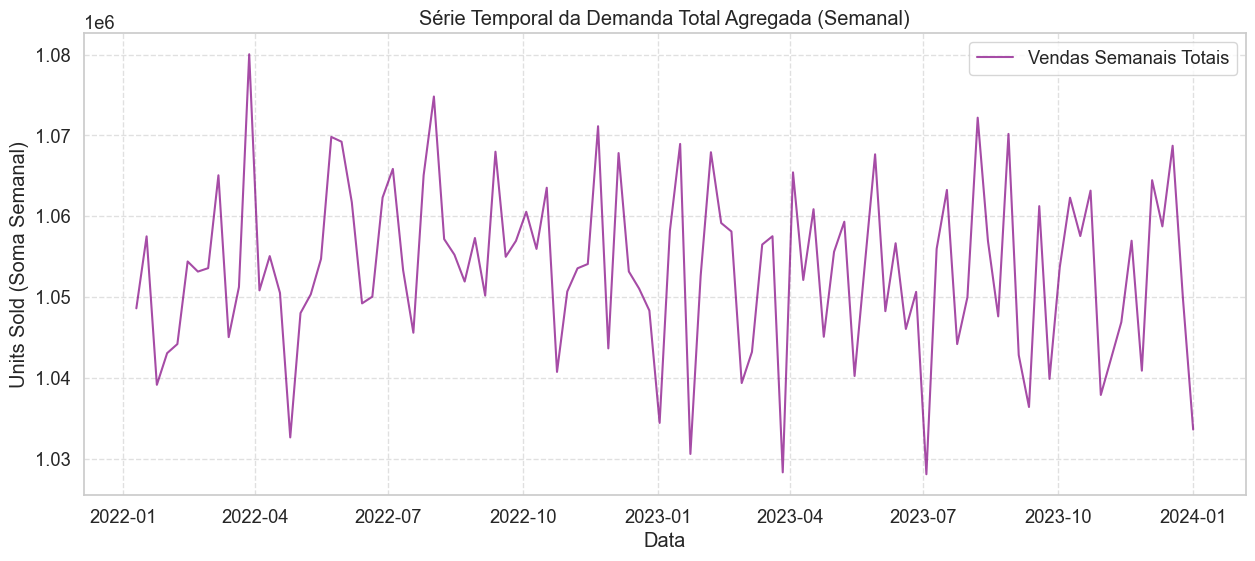

In [50]:
# Soma Units Sold por data para obter a demanda total diária
df_agg = merged_df.groupby('Date')['UnitsSold'].sum().reset_index()
# df_agg = df_agg[df_agg['Date'] <= '2022-01-10']

# Plotagem
plt.figure(figsize=(15, 6))

plt.plot(df_agg['Date'], df_agg['UnitsSold'], color='purple', alpha=0.7, label='Vendas Semanais Totais')

plt.title('Série Temporal da Demanda Total Agregada (Semanal)')
plt.xlabel('Data')
plt.ylabel('Units Sold (Soma Semanal)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

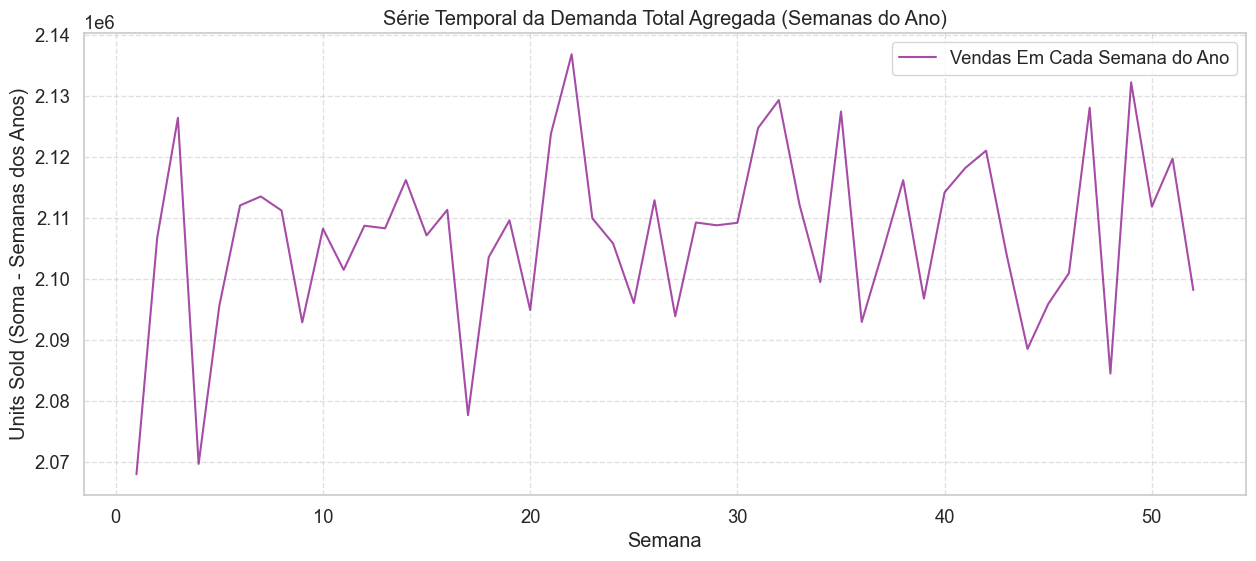

In [51]:
# Soma Units Sold por data para obter a demanda total diária
df_agg = merged_df.groupby('Week')['UnitsSold'].sum().reset_index()

# Plotagem
plt.figure(figsize=(15, 6))

plt.plot(df_agg['Week'], df_agg['UnitsSold'], color='purple', alpha=0.7, label='Vendas Em Cada Semana do Ano')

plt.title('Série Temporal da Demanda Total Agregada (Semanas do Ano)')
plt.xlabel('Semana')
plt.ylabel('Units Sold (Soma - Semanas dos Anos)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

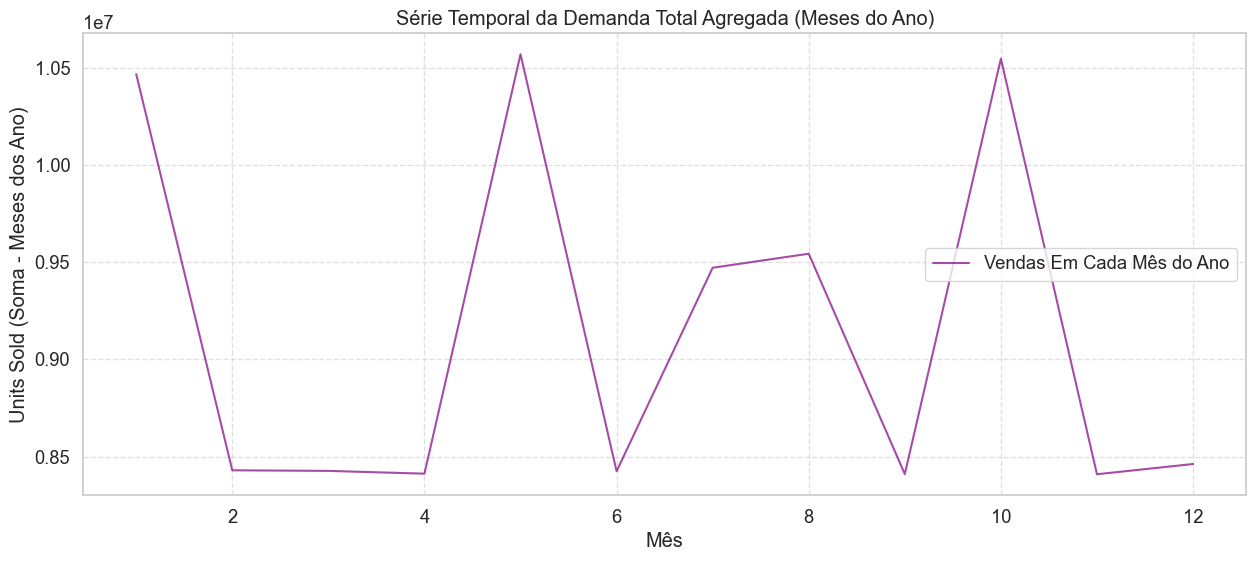

In [52]:
# Soma Units Sold por data para obter a demanda total diária
df_agg = merged_df.groupby('Month')['UnitsSold'].sum().reset_index()

# Plotagem
plt.figure(figsize=(15, 6))

plt.plot(df_agg['Month'], df_agg['UnitsSold'], color='purple', alpha=0.7, label='Vendas Em Cada Mês do Ano')

plt.title('Série Temporal da Demanda Total Agregada (Meses do Ano)')
plt.xlabel('Mês')
plt.ylabel('Units Sold (Soma - Meses dos Ano)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### Detalhes sobre a série temporal

- Ao analisar pelo período completo, semana do ano e mês, vemos a sazonalidade mais explícita ao analisar os meses
- Janeiro, Maio e Outubro indicam maiores picos de sazonalidade, podendo envolver questões como promoções ou feriados que aumentam as compras

In [53]:
## realizando a verificação de métricas basicas para entendimento do comportamento dos dados

print("Média de Units Sold:", merged_df['UnitsSold'].mean())
print("Mediana de Units Sold:", merged_df['UnitsSold'].median())
print("Desvio Padrão de Units Sold:", merged_df['UnitsSold'].std())
print("Quantil 25% de Units Sold:", merged_df['UnitsSold'].quantile(0.25))
print("Quantil 50% de Units Sold:", merged_df['UnitsSold'].quantile(0.50))
print("Quantil 75% de Units Sold:", merged_df['UnitsSold'].quantile(0.75))
print("quantil 90% de Units Sold:", merged_df['UnitsSold'].quantile(0.90))


Média de Units Sold: 144.52662346484257
Mediana de Units Sold: 114.0
Desvio Padrão de Units Sold: 120.10470319479352
Quantil 25% de Units Sold: 49.0
Quantil 50% de Units Sold: 114.0
Quantil 75% de Units Sold: 215.0
quantil 90% de Units Sold: 321.0


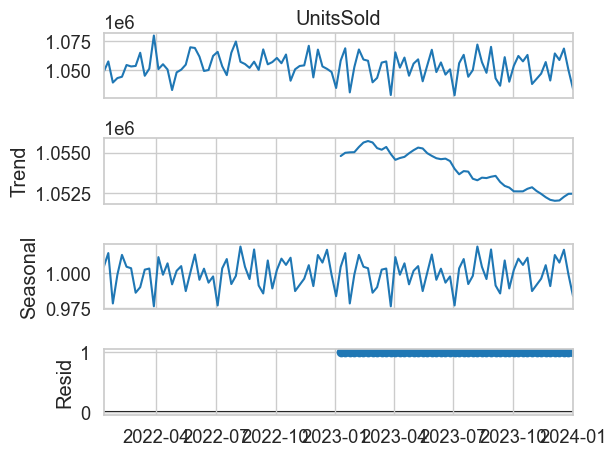

Tendência: 1053942.0110946747
Sazonalidade: 1.0
Observado: 1053581.0192307692
Residual: 0.9985972172212225


In [54]:
## Analide de decomposição sazonal
merged_df = merged_df.sort_values('Date')

series = merged_df.groupby('Date')['UnitsSold'].sum()

result = seasonal_decompose(series, model='multiplicative', period=52, two_sided=False)
result.plot()
plt.show()

print("Tendência:", result.trend.mean())
print("Sazonalidade:", result.seasonal.mean())
print("Observado:",result.observed.mean())
print("Residual:",result.resid.mean())

Analisando categoria: Clothing


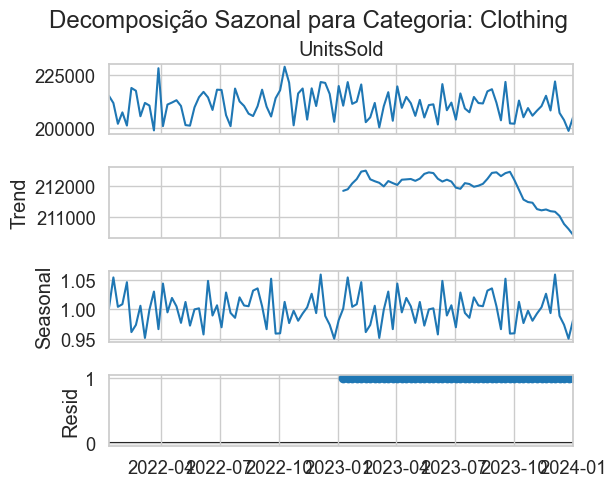

Tendência: 211927.93768491125
Sazonalidade: 1.0
Observado: 211096.95192307694
Residual: 0.9923591027412055


Analisando categoria: Electronics


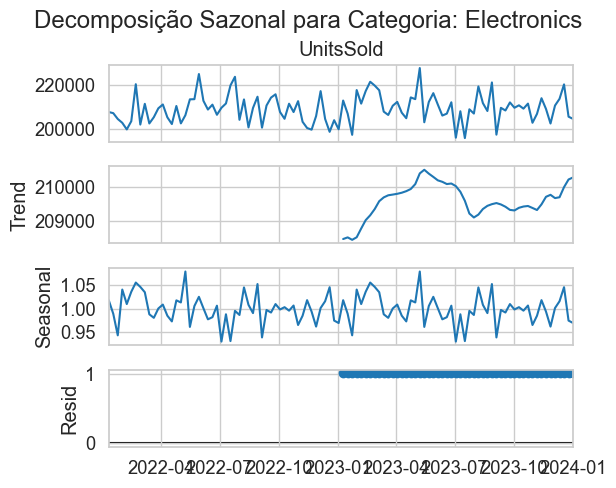

Tendência: 209599.56952662722
Sazonalidade: 1.0
Observado: 209378.11538461538
Residual: 1.003509767362849


Analisando categoria: Furniture


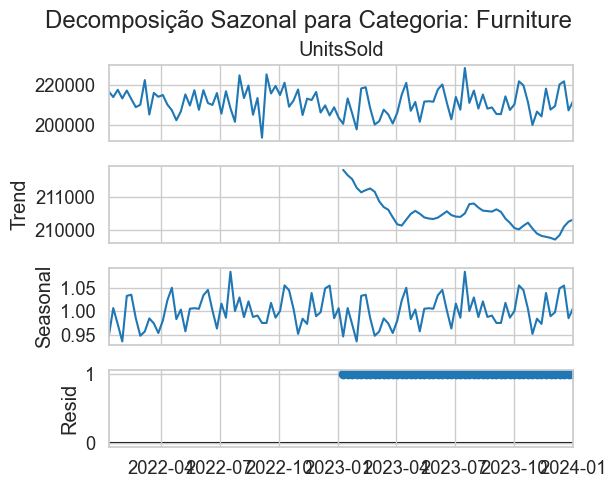

Tendência: 210489.13073224854
Sazonalidade: 0.9999999999999999
Observado: 211185.375
Residual: 0.9995384817256343


Analisando categoria: Groceries


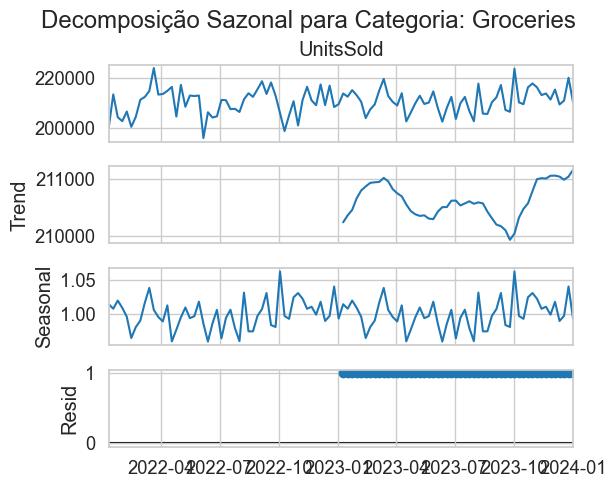

Tendência: 210611.00591715978
Sazonalidade: 0.9999999999999998
Observado: 210635.57692307694
Residual: 1.0026433987428651


Analisando categoria: Toys


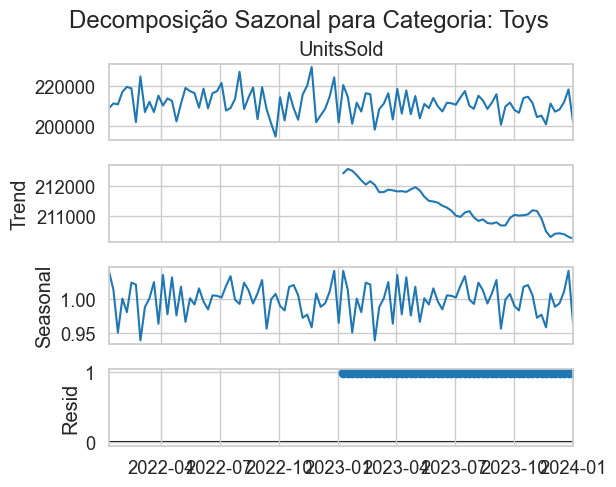

Tendência: 211314.3672337278
Sazonalidade: 1.0
Observado: 211285.0
Residual: 0.99502496859463




In [55]:
## Como há pouca sazonalidade aparente, vamos tentar com o desagrupamento, agora por categoria

merged_df = merged_df.sort_values('Date')

for category in merged_df['Category'].unique():
    print(f"Analisando categoria: {category}")
    category_df = merged_df[merged_df['Category'] == category]
    series = category_df.groupby('Date')['UnitsSold'].sum()
    
    result = seasonal_decompose(series, model='multiplicative', period=52, two_sided=False)
    result.plot()
    plt.suptitle(f'Decomposição Sazonal para Categoria: {category}', y=1.02)
    plt.show()

    print("Tendência:", result.trend.mean())
    print("Sazonalidade:", result.seasonal.mean())
    print("Observado:",result.observed.mean())
    print("Residual:",result.resid.mean())
    print('\n')

### Poucos indicativos

Apesar de podermos verificar alguns padrões, a decomposição sazonal não demonstrou grandes detalhes dentro do período analisado

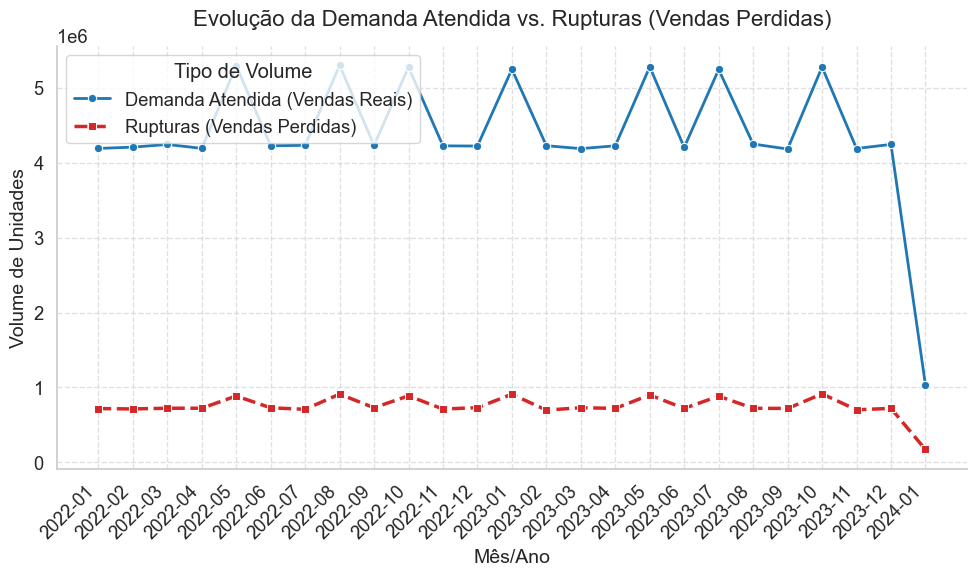

In [56]:
## Vendas x rupturas

# Configuração do estilo do gráfico
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# --- 1. Preparação dos Dados (Agregação Mensal) ---
# Certificar-se de que a coluna 'Date' está no formato datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Criar a coluna Mês/Ano para agregação
merged_df['MonthYear'] = merged_df['Date'].dt.to_period('M')

# Agregação: Soma das Unidades Vendidas e Vendas Perdidas por Mês
monthly_performance = merged_df.groupby('MonthYear').agg(
    TotalUnitsSold=('UnitsSold', 'sum'),
    TotalMissedSales=('MissedSales', 'sum')
).reset_index()

monthly_performance['Diff Percent'] = (
    (monthly_performance['TotalMissedSales'] / monthly_performance['TotalUnitsSold']) * 100
).round(2) 



# Ordenar e formatar a coluna para o eixo X
monthly_performance = monthly_performance.sort_values('MonthYear')
monthly_performance['MonthYearStr'] = monthly_performance['MonthYear'].astype(str)

# --- 2. Geração do Gráfico ---
plt.figure(figsize=(10, 6))

# Gráfico de Vendas (TotalUnitsSold)
sns.lineplot(
    data=monthly_performance,
    x='MonthYearStr',
    y='TotalUnitsSold',
    label='Demanda Atendida (Vendas Reais)',
    marker='o',
    linewidth=2,
    color='tab:blue'
)

# Gráfico de Rupturas (TotalMissedSales)
sns.lineplot(
    data=monthly_performance,
    x='MonthYearStr',
    y='TotalMissedSales',
    label='Rupturas (Vendas Perdidas)',
    marker='s',
    linewidth=2.5,
    linestyle='--',
    color='tab:red'
)

# Adicionando Títulos e Rótulos
plt.title('Evolução da Demanda Atendida vs. Rupturas (Vendas Perdidas)', fontsize=16, pad=15)
plt.xlabel('Mês/Ano', fontsize=14)
plt.ylabel('Volume de Unidades', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotação para melhor visualização dos meses
plt.legend(title='Tipo de Volume', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Remover a borda superior e direita para estética limpa
sns.despine()

# Mostrar o Gráfico
plt.tight_layout()
plt.show()

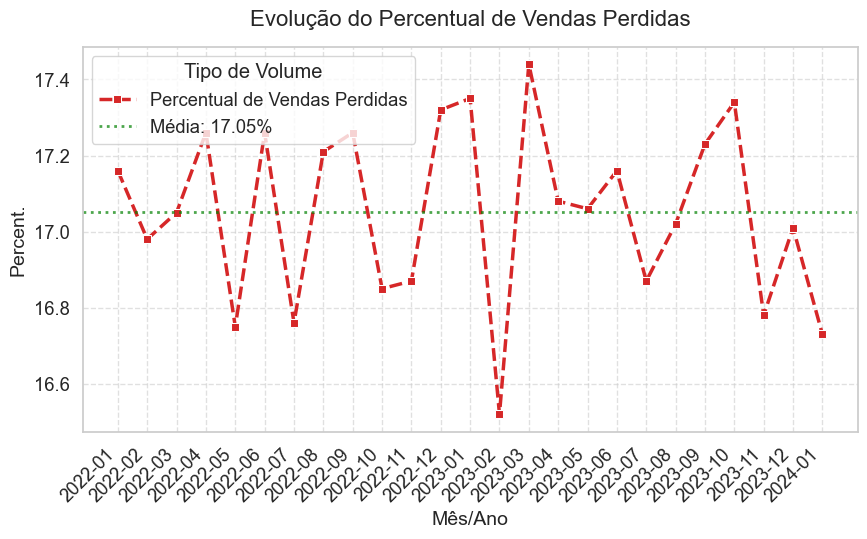

In [57]:
# monthly_performance['Diff Percent'].mean()

plt.figure(figsize=(10, 5))

# Gráfico do Percentual de Rupturas
sns.lineplot(
    data=monthly_performance,
    x='MonthYearStr',
    y='Diff Percent',
    label='Percentual de Vendas Perdidas',
    marker='s',
    linewidth=2.5,
    linestyle='--',
    color='tab:red'
)

# Adicionar linha de média
media_diff_percent = monthly_performance['Diff Percent'].mean()
plt.axhline(
    y=media_diff_percent,
    color='green',
    linestyle=':',
    linewidth=2,
    label=f'Média: {media_diff_percent:.2f}%',
    alpha=0.7
)

# Adicionando Títulos e Rótulos
plt.title('Evolução do Percentual de Vendas Perdidas', fontsize=16, pad=15)
plt.xlabel('Mês/Ano', fontsize=14)
plt.ylabel('Percent.', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotação para melhor visualização dos meses
plt.legend(title='Tipo de Volume', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

### Indicações iniciais sobre a sazonalidade:
- Em um primeiro momento, os dados não indicam grandes "picos" para notar uma sazonalidade que possa trazer um maior insight
- No plano sobre a decomposição por categoria, observamos o mesmo efeito, já que não há uma diferença significativa nos resultados

Para uma verificação maior, teremos que descer para nível de produto e loja

<Figure size 1000x500 with 0 Axes>

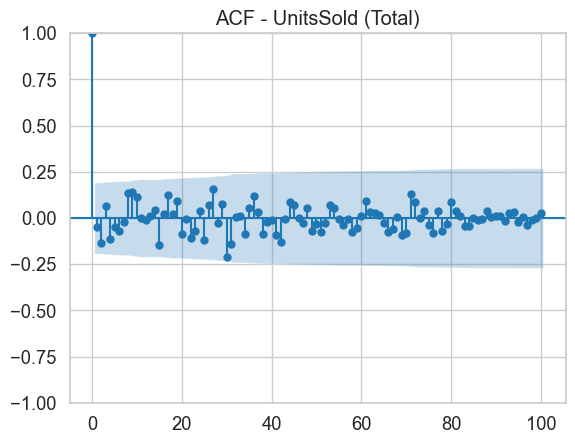

In [58]:
## Primeiro, verificamos que os dados agregados não apresentam sazonalidade clara com a análise por ACF

from statsmodels.graphics.tsaplots import plot_acf

series = merged_df.groupby('Date')['UnitsSold'].sum().sort_index()

plt.figure(figsize=(10,5))
plot_acf(series, lags=100)  # 100 lags ~ 2 anos de defasagens semanais
plt.title("ACF - UnitsSold (Total)")
plt.show()

In [59]:
# Como vimos acima, por meio de uma granularidade não tão grande, não há sazonalidade clara nos dados agregados.
# Iremos descer ao nível produto x loja, mas para focarmos em poucos exemplos, vamos selecionar a partir da curva ABC

abc = (merged_df.groupby("Product ID")["NetRevenue"]
       .sum()
       .sort_values(ascending=False))

total = abc.sum()
abc_pct = (abc / total).cumsum()

abc_class = pd.cut(
    abc_pct,
    bins=[0, 0.65, 0.90, 1.0],
    labels=["A", "B", "C"]
)

abc_df = pd.DataFrame({
    "Netrevenue_Total": abc,
    "CumulativePct": abc_pct,
    "Class": abc_class
})

abc_df.Class.value_counts()

Class
A    48
B    19
C     8
Name: count, dtype: int64

In [60]:
# merged_df[merged_df['InventoryLevel'] == 0]
abc_df.head(10)

,Netrevenue_Total,CumulativePct,Class
Product ID,,,
P0069,73109599.46,0.013582,A
P0007,73097293.87,0.027161,A
P0019,73056702.67,0.040733,A
P0032,72925858.77,0.054281,A
P0042,72925696.83,0.067829,A
P0015,72923959.53,0.081376,A
P0061,72871878.87,0.094914,A
P0060,72853316.95,0.108448,A
P0072,72810602.97,0.121975,A


In [61]:
## Análise XYZ - Baseada na Variabilidade/Previsibilidade da Demanda

# Calcular coeficiente de variação (CV) por produto
xyz_stats = merged_df.groupby('Product ID').agg({
    'UnitsSold': ['mean', 'std', 'count']
}).reset_index()

xyz_stats.columns = ['Product ID', 'Mean_UnitsSold', 'Std_UnitsSold', 'Count']

# Calcular coeficiente de variação (CV = std / mean)
# Evitar divisão por zero
xyz_stats['CV'] = (xyz_stats['Std_UnitsSold'] / xyz_stats['Mean_UnitsSold'].replace(0, np.nan)).fillna(0)

# Ordenar por CV
xyz_stats = xyz_stats.sort_values('CV', ascending=False).reset_index(drop=True)

# Classificar em X, Y, Z baseado em percentis de CV
# X: baixa variabilidade (CV < 33º percentil) - previsível
# Y: variabilidade moderada (33º < CV < 66º percentil)
# Z: alta variabilidade (CV > 66º percentil) - imprevisível
p33 = xyz_stats['CV'].quantile(0.33)
p66 = xyz_stats['CV'].quantile(0.66)

xyz_stats['Class_XYZ'] = pd.cut(
    xyz_stats['CV'],
    bins=[0, p33, p66, np.inf],
    labels=['X', 'Y', 'Z'],
    right=False
)

print(f"Limites CV - X (<{p33:.3f}), Y ({p33:.3f}-{p66:.3f}), Z (>{p66:.3f})")
print("\nDistribuição XYZ:")
print(xyz_stats['Class_XYZ'].value_counts().sort_index())

xyz_stats.head(15)


Limites CV - X (<0.827), Y (0.827-0.834), Z (>0.834)

Distribuição XYZ:
Class_XYZ
X    25
Y    24
Z    26
Name: count, dtype: int64


,Product ID,Mean_UnitsSold,Std_UnitsSold,Count,CV,Class_XYZ
0,P0009,143.475665,121.356905,10150,0.845836,Z
1,P0017,142.901291,120.638452,10070,0.844208,Z
2,P0037,144.530903,121.921459,10096,0.843567,Z
3,P0022,144.998510,121.990367,10070,0.841322,Z
4,P0039,143.788207,120.922473,10142,0.840976,Z
5,P0044,143.299604,120.499898,10090,0.840895,Z
6,P0013,143.340392,120.490758,10106,0.840592,Z
7,P0051,144.301784,121.288542,10090,0.840520,Z
8,P0016,144.609010,121.482558,10100,0.840076,Z
9,P0066,143.860727,120.761656,10124,0.839434,Z


In [62]:
merged_df = pd.merge(
    merged_df,
    xyz_stats[['Product ID', 'Class_XYZ']],
    on='Product ID',
    how='left'
).merge(
    abc_df[['Class']],    
    on='Product ID',
    how='left'
)


In [63]:
print("Contagem de Produtos por Quadrante ABC-XYZ:")
print(merged_df[['Product ID', 'Class', 'Class_XYZ']].drop_duplicates().pivot_table(
    index='Class_XYZ', columns='Class', aggfunc='size', fill_value=0
))

Contagem de Produtos por Quadrante ABC-XYZ:
Class       A   B  C
Class_XYZ           
X          21   3  1
Y          15   5  4
Z          12  11  3


C:\Users\sergi\AppData\Local\Temp\ipykernel_27464\912396552.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  print(merged_df[['Product ID', 'Class', 'Class_XYZ']].drop_duplicates().pivot_table(


In [64]:
## Com as classificações ABC e XYZ atribuídas, podemos agora focar em produtos específicos para análises mais detalhadas.
## primeiramente, iremos colocar as informações de safety stock no dataframe principal.

# ---- Service level mapping (por combinação ABC+XYZ) ----
# Define explicitamente o nível de serviço alvo por quadrante
SERVICE_LEVEL_MAP = {
    'AX': 0.95, 'AY': 0.95, 'BX': 0.95, 'BY': 0.95,
    'AZ': 0.85, 'BZ': 0.85, 'CX': 0.85, 'CY': 0.85,
    'CZ': 0.75
}

def get_service_level(abc_class, xyz_class, default=0.90):
    grp = f"{abc_class}{xyz_class}"
    return SERVICE_LEVEL_MAP.get(grp, default)

# Aplicar o nível de serviço e calcular Z (fator normal) por linha
merged_df['ServiceLevel'] = merged_df.apply(
    lambda r: get_service_level(r['Class'], r['Class_XYZ']),
    axis=1
)
merged_df['Z_Factor'] = merged_df['ServiceLevel'].apply(lambda p: float(norm.ppf(p)))

# Premissa: Lead Time (LT) = 2 Semanas (t+2)
LEAD_TIME_WEEKS = 2

# Calcular o desvio padrão da demanda por período (sigma) usando uma janela razoável
# Usamos um window mínimo para estimar sigma por período e então escalamos para LT.
WINDOW_FOR_SIGMA = max(LEAD_TIME_WEEKS, 4)

sigma_per_period = (
    merged_df.groupby(['Store ID', 'Product ID'])['UnitsSold']
    .transform(lambda x: x.shift(1).rolling(window=WINDOW_FOR_SIGMA, min_periods=1).std())
    .fillna(0)
)

# Desvio padrão da demanda durante o lead time (assumindo independência entre períodos):
# sigma_LT = sigma_per_period * sqrt(LEAD_TIME_WEEKS)
merged_df['RollingStd_Demand_LT'] = sigma_per_period * np.sqrt(LEAD_TIME_WEEKS)

# -----------------------------------------------------------
# 3. Calcular o Safety Stock (SS)
# -----------------------------------------------------------

# Safety Stock = Z * sigma_LT
merged_df['SafetyStock'] = merged_df['Z_Factor'] * merged_df['RollingStd_Demand_LT']

# Safety stock deve ser um número inteiro, arredondado para cima para garantir o serviço.
merged_df['SafetyStock'] = np.ceil(merged_df['SafetyStock']).astype(int)

In [65]:
# Exibir os resultados para um produto em diversas classificações, como AX
print("Safety Stock calculado por Fator Z (SL) estratégico:")
merged_df[
    (merged_df['Class'] == 'B') & (merged_df['Class_XYZ'] == 'Z')
].tail(5)[['Date', 'Product ID', 'DemandForecast', 'UnitsSold', 'Class', 'Class_XYZ', 'Z_Factor', 'RollingStd_Demand_LT', 'SafetyStock']]

Safety Stock calculado por Fator Z (SL) estratégico:


,Date,Product ID,DemandForecast,UnitsSold,Class,Class_XYZ,Z_Factor,RollingStd_Demand_LT,SafetyStock
758140,2024-01-01,P0049,381.22,0,B,Z,1.036433,138.281717,144
758141,2024-01-01,P0049,167.20,138,B,Z,1.036433,184.450084,192
758142,2024-01-01,P0049,101.40,86,B,Z,1.036433,174.731699,182
758143,2024-01-01,P0049,187.87,29,B,Z,1.036433,144.855675,151
758144,2024-01-01,P0049,397.13,176,B,Z,1.036433,86.713129,90


In [66]:
GROUP_COLS = ['Store ID', 'Product ID']
LEAD_TIME_WEEKS = 2 # Seu Lead Time é de 2 semanas (pedido em t, chega em t+2)

# Deve estar ordenado cronologicamente
merged_df = merged_df.sort_values(['Store ID', 'Product ID', 'Date']).reset_index(drop=True)

# O cálculo deve usar a média móvel da demanda (UnitsSold) dos últimos 2 períodos (LT).
# O .shift(1) garante que estamos usando dados do PASSADO para prever o futuro (evita vazamento de dados).
merged_df['AvgDemand_LT'] = (
    merged_df.groupby(GROUP_COLS)['UnitsSold']
    .transform(lambda x: x.shift(1).rolling(window=LEAD_TIME_WEEKS, min_periods=1).mean())
    .fillna(0)
)

# ROP (Reorder point) = Demanda Média no LT + Safety Stock
merged_df['ReorderPoint'] = (
    merged_df['AvgDemand_LT']
    + merged_df['SafetyStock']
)

# O ROP deve ser um número inteiro (arredondado para cima é mais conservador, usaremos em nosso estudo)
merged_df['ReorderPoint'] = np.ceil(merged_df['ReorderPoint']).astype(int)

# Verificar se o estoque disponível (InventoryAvailable) está abaixo do ROP
# Nota: InventoryAvailable (EndInventory + StockInTransit) foi calculado anteriormente
merged_df['ROP_Hit'] = np.where(
    merged_df['InventoryAvailable'] <= merged_df['ReorderPoint'],
    1, # Condição atingida, deve pedir
    0  # Não precisa pedir
)

# Exibir os resultados (usando o mesmo filtro de exemplo)
print("\nRecálculo da Política de Ressuprimento (Reorder Point):")
merged_df[
    (merged_df['Store ID'] == 'S001') & (merged_df['Product ID'] == 'P0001') & (merged_df['Date'] == max(merged_df['Date']))
].head(7)[['Date', 'UnitsSold', 'SafetyStock', 'AvgDemand_LT', 'ReorderPoint', 'EndInventory', 'StockInTransit', 'InventoryAvailable', 'ROP_Hit']]


Recálculo da Política de Ressuprimento (Reorder Point):


,Date,UnitsSold,SafetyStock,AvgDemand_LT,ReorderPoint,EndInventory,StockInTransit,InventoryAvailable,ROP_Hit
663,2024-01-01,87,147,162.0,309,335,94,429,0
664,2024-01-01,115,118,144.5,263,238,192,430,0
665,2024-01-01,6,115,101.0,216,464,156,620,0
666,2024-01-01,84,189,60.5,250,124,142,266,0
667,2024-01-01,203,109,45.0,154,62,18,80,1
668,2024-01-01,334,190,143.5,334,112,82,194,1


In [67]:
# Usaremos a Demanda Média no LT (AvgDemand_LT, com LD = 2 semanas) + Safety Stock
# O ROP já é a combinação dos dois! 
# Para manter a lógica separada, vamos definir:
# OUL = ROP + Demanda Média durante o Ciclo de Revisão (Se Revisão = 1 semana)

# Se o pedido for feito na Sexta e o novo pedido chegar 10 dias depois, o OUL deve cobrir a demanda até a próxima chegada.
# OUL = Demanda Média (2 semanas) + Safety Stock

# Em muitos sistemas (Q,R), ROP = Demanda LT + SS. OUL é determinado pelo tamanho do lote de compra.
# Em (T, S), S = OUL = Demanda (LT + T) + SS.

# Vamos simplificar: O OUL será a demanda média que deve ser coberta.
# Assumindo que você quer ter estoque suficiente para 4 semanas (2x o LT)
COVERAGE_WEEKS = 4

# Demanda Média Móvel para 4 semanas
merged_df['AvgDemand_4_Weeks'] = (
    merged_df.groupby(GROUP_COLS)['UnitsSold']
    .transform(lambda x: x.shift(1).rolling(window=COVERAGE_WEEKS, min_periods=1).mean())
    .fillna(0)
)

# Estoque Máximo (OUL) para cobrir 4 semanas de demanda + Safety Stock
merged_df['OrderUpToLevel'] = (
    (merged_df['AvgDemand_4_Weeks'] * COVERAGE_WEEKS)
    + merged_df['SafetyStock']
)

# ----------------------------------------------------
# 2. Calcular a Quantidade de Pedido (Order Quantity - OQ)
# ----------------------------------------------------

# OQ = OUL - Inventory Available (o que está no estoque ou em trânsito)
merged_df['OrderQuantity'] = (
    merged_df['OrderUpToLevel'] - merged_df['InventoryAvailable']
).clip(lower=0) # Nunca peça negativo

merged_df['OrderQuantity'] = np.ceil(merged_df['OrderQuantity']).astype(int)


# Visualizar o Safety Stock no contexto do OrderUpTo
print("\nSafety Stock em relação ao Estoque Máximo (Order Up To Level):")
merged_df[
    (merged_df['Store ID'] == 'S001') & (merged_df['Product ID'] == 'P0001')
].head(7)[['Date', 'UnitsSold', 'SafetyStock', 'ReorderPoint', 'OrderUpToLevel', 'InventoryAvailable', 'OrderQuantity']]


Safety Stock em relação ao Estoque Máximo (Order Up To Level):


,Date,UnitsSold,SafetyStock,ReorderPoint,OrderUpToLevel,InventoryAvailable,OrderQuantity
0,2022-01-10,80,0,0,0.0,298,0
1,2022-01-10,428,0,80,320.0,294,26
2,2022-01-10,47,573,827,1589.0,556,1033
3,2022-01-10,375,492,730,1232.0,125,1107
4,2022-01-10,344,458,669,1388.0,104,1284
5,2022-01-17,201,399,759,1593.0,160,1433
6,2022-01-17,114,350,623,1317.0,210,1107


In [68]:
## Realizando a análise de Unit Fill Rate (UFR)
## Com isso, podemos ter uma visão clara sobre o desempenho do atendimento de pedidos em função do estoque disponível

merged_df['UFR'] = merged_df['UnitsSold'] / (merged_df['UnitsSold'] + merged_df['MissedSales'])
merged_df['UFR'] = merged_df['UFR'].fillna(1.0)  # Se não houver vendas perdidas, UFR é 100%

print("Análise de Unit Fill Rate (UFR) por Produto e Loja:")
merged_df[
    (merged_df['Store ID'] == 'S001') & (merged_df['Product ID'] == 'P0001')
].head(10)[['Date', 'UnitsSold', 'MissedSales', 'UFR']]

Análise de Unit Fill Rate (UFR) por Produto e Loja:


,Date,UnitsSold,MissedSales,UFR
0,2022-01-10,80,0.00,1.000000
1,2022-01-10,428,52.86,0.890072
2,2022-01-10,47,0.00,1.000000
3,2022-01-10,375,0.00,1.000000
4,2022-01-10,344,118.01,0.744573
5,2022-01-17,201,0.00,1.000000
6,2022-01-17,114,0.00,1.000000
7,2022-01-17,27,0.00,1.000000
8,2022-01-17,131,96.17,0.576661
9,2022-01-17,197,0.00,1.000000


In [69]:
print('\nVerificando os resultados de Unit Fill Rate por classe ABC e XYZ') 
merged_df.groupby(['Class', 'Class_XYZ'])['UFR'].mean().to_frame()



Verificando os resultados de Unit Fill Rate por classe ABC e XYZ


C:\Users\sergi\AppData\Local\Temp\ipykernel_27464\4191219717.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby(['Class', 'Class_XYZ'])['UFR'].mean().to_frame()


UFR
Class Class_XYZ          
A     X          0.896867
      Y          0.896044
      Z          0.897041
B     X          0.896972
      Y          0.895378
      Z          0.896521
C     X          0.895028
      Y          0.896702
      Z          0.896957

In [70]:
print('Verificando os resultados de Bias por classe ABC e XYZ')
merged_df.groupby(['Class', 'Class_XYZ'])['BIAS'].mean().to_frame()

Verificando os resultados de Bias por classe ABC e XYZ


C:\Users\sergi\AppData\Local\Temp\ipykernel_27464\2537022812.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby(['Class', 'Class_XYZ'])['BIAS'].mean().to_frame()


BIAS
Class Class_XYZ           
A     X           7.785544
      Y           8.829254
      Z           8.101668
B     X           9.647747
      Y          10.173247
      Z           9.782384
C     X          10.500365
      Y          10.650647
      Z          11.199809

## Resultados da análise inicial

Vemos que:
- Os dados de safety stock estão bem parelhos, tendo um baixo percentual para casos mais relevantes (AX)
- Os dados mais variáveis, como os da seção CZ, estão com o mesmo percentual, o que pode impactar no custo de posse

Iremos fazer uma correção de safet stock, baseado no Bias por cada seção ABC-XYZ, procurando melhorar os níveis de safety stock

In [71]:
## Havendo essa diferença entre o esperado para produtos AX (95%) e o real (89%), e com o alto valor de SS para produtos menos relevantes
## Devemos revisar os níveis de serviço (Z-Factor)

GROUP_COLS = ['Store ID', 'Product ID']
LEAD_TIME_WEEKS = 2

# 1. Calcular o Desvio Padrão Móvel do Viés (Erro) no LT
merged_df['RollingStd_Bias_LT'] = (
    merged_df.groupby(GROUP_COLS)['BIAS']
    .transform(lambda x: x.shift(1).rolling(window=LEAD_TIME_WEEKS, min_periods=1).std())
    .fillna(0)
)

# Relembrar o Fator Z (do Passo 2)
# merged_df['Z_Factor'] já deve existir com os valores Z para 95%, 85%, etc.

# 2. Recalcular o Safety Stock (SS)
merged_df['SafetyStock_Revisado'] = (
    merged_df['Z_Factor'] * merged_df['RollingStd_Bias_LT']
)

# Arredondar para cima
merged_df['SafetyStock_Revisado'] = np.ceil(merged_df['SafetyStock_Revisado']).astype(int)

# 3. Substituir o Safety Stock Antigo
merged_df['SafetyStock'] = merged_df['SafetyStock_Revisado']

# 1. Recalcular o ROP
merged_df['ReorderPoint_Revisado'] = (
    merged_df['AvgDemand_LT'] # Demanda Média no LT (não muda)
    + merged_df['SafetyStock']
)
merged_df['ReorderPoint'] = np.ceil(merged_df['ReorderPoint_Revisado']).astype(int)

# 2. Recalcular o OUL (Seu cálculo de OUL cobria 4 semanas de demanda + SS)
COVERAGE_WEEKS = 4 
merged_df['OrderUpToLevel_Revisado'] = (
    (merged_df['AvgDemand_4_Weeks'] * COVERAGE_WEEKS)
    + merged_df['SafetyStock']
)
merged_df['OrderUpToLevel'] = np.ceil(merged_df['OrderUpToLevel_Revisado']).astype(int)

# 3. Recalcular a Quantidade de Pedido (OQ)
merged_df['OrderQuantity'] = (
    merged_df['OrderUpToLevel'] - merged_df['InventoryAvailable']
).clip(lower=0)
merged_df['OrderQuantity'] = np.ceil(merged_df['OrderQuantity']).astype(int)

print("\nSafety Stock Revisado e Impacto no ROP (Amostra):")
merged_df[
    (merged_df['Store ID'] == 'S001') & (merged_df['Product ID'] == 'P0001')
].tail(5)[['Date', 'BIAS', 'RollingStd_Bias_LT', 'SafetyStock', 'ReorderPoint', 'OrderQuantity']]


Safety Stock Revisado e Impacto no ROP (Amostra):


,Date,BIAS,RollingStd_Bias_LT,SafetyStock,ReorderPoint,OrderQuantity
664,2024-01-01,238.91,165.067007,272,417,422
665,2024-01-01,16.40,181.966859,300,401,206
666,2024-01-01,4.77,157.338330,259,320,403
667,2024-01-01,18.81,8.223652,14,59,226
668,2024-01-01,-104.47,9.927779,17,161,231


In [72]:
# Importante agora revisar as mudanças no Safety Stock antigo vs. revisado
group_df = merged_df.copy()

print("\nComparativo: Safety Stock Antigo vs. Revisado")

# Exemplo de cálculo do SS Antigo (baseado no Desvio Padrão da Demanda)
group_df['SS_Antigo_Temp'] = (
    group_df['Z_Factor'] * group_df['RollingStd_Demand_LT']
)
group_df['SS_Antigo_Temp'] = np.ceil(group_df['SS_Antigo_Temp']).astype(int)

comparativo_ss = group_df.groupby(['Class', 'Class_XYZ']).agg(
    Avg_SS_Antigo=('SS_Antigo_Temp', 'mean'),
    Avg_SS_Revisado=('SafetyStock', 'mean'),
    Avg_ROP_Revisado=('ReorderPoint', 'mean'),
    Num_Orders_Revisadas=('ROP_Hit', 'sum') # Quantidade de vezes que a nova política mandou pedir
).reset_index()

comparativo_ss


Comparativo: Safety Stock Antigo vs. Revisado


C:\Users\sergi\AppData\Local\Temp\ipykernel_27464\685399287.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comparativo_ss = group_df.groupby(['Class', 'Class_XYZ']).agg(


,Class,Class_XYZ,Avg_SS_Antigo,Avg_SS_Revisado,Avg_ROP_Revisado,Num_Orders_Revisadas
0,A,X,251.313014,210.526147,356.041808,147203
1,A,Y,251.913069,210.219138,355.013595,104870
2,A,Z,160.516046,133.262026,278.636406,67272
3,B,X,248.867176,210.339995,353.868723,20747
4,B,Y,249.142396,209.404023,353.057466,34453
5,B,Z,158.743260,132.559433,276.312300,60708
6,C,X,154.930891,129.962879,272.908184,5476
7,C,Y,156.542348,131.829843,274.104845,21834
8,C,Z,103.001123,85.810737,228.813479,13209


In [73]:
if 'MissedSales' not in group_df.columns:
    # Preferir cálculo baseado em Forecast vs InventoryAvailable (se existir)
    if 'InventoryAvailable' in group_df.columns and 'DemandForecast' in group_df.columns:
        group_df['MissedSales'] = (group_df['DemandForecast'] - group_df['InventoryAvailable']).clip(lower=0)
    elif 'InventoryLevel' in group_df.columns and 'DemandForecast' in group_df.columns:
        group_df['MissedSales'] = (group_df['DemandForecast'] - group_df['InventoryLevel']).clip(lower=0)
    else:
        # fallback conservador: usar UnitsSold vs 0 (nenhuma perda conhecida)
        group_df['MissedSales'] = 0

# 2. Criar a Rupture Flag
group_df['RuptureFlag'] = np.where(
    group_df['MissedSales'] > 0,
    1, # Houve ruptura nesta semana
    0  # Não houve ruptura
)

print("\nCriação das Flags de Ruptura (Amostra):")
group_df.head(5)[['Date', 'UnitsSold', 'InventoryLevel', 'MissedSales', 'RuptureFlag']]


Criação das Flags de Ruptura (Amostra):


,Date,UnitsSold,InventoryLevel,MissedSales,RuptureFlag
0,2022-01-10,80,275,0.00,0
1,2022-01-10,428,495,52.86,1
2,2022-01-10,47,432,0.00,0
3,2022-01-10,375,330,0.00,0
4,2022-01-10,344,39,118.01,1


In [74]:
# 1. Re-execução do cálculo de Performance
performance_by_group = group_df.groupby(['Class', 'Class_XYZ']).agg(
    TotalUnitsSold=('UnitsSold', 'sum'),
    TotalMissedSales=('MissedSales', 'sum'),
    NumRuptures=('RuptureFlag', 'sum'),
    NumWeeks=('Date', 'count')
).reset_index()

# Calcular o UFR Agregado por Grupo
performance_by_group['TotalDemand'] = performance_by_group['TotalUnitsSold'] + performance_by_group['TotalMissedSales']
performance_by_group['Aggregated_UFR'] = np.where(
    performance_by_group['TotalDemand'] > 0,
    performance_by_group['TotalUnitsSold'] / performance_by_group['TotalDemand'],
    1.0
)

# 2. Comparativo da Cobertura de Risco da NOVA Política (Passo de Validação)
# Frequência de Ruptura Real: Ruptura que ocorreu com a política ANTIGA (UFR ~89.7%)
ruptura_comparativo = performance_by_group[['Class', 'Class_XYZ', 'TotalMissedSales', 'Aggregated_UFR']].copy()

# Frequência de Cobertura Pelo NOVO SS: 
# Usaremos a lógica de cobertura que criamos anteriormente para inferir se o NOVO SS seria suficiente.

# 2a. Calcular o excesso de demanda que o Safety Stock deveria cobrir
group_df['Demand_Exceeded_Avg'] = (group_df['UnitsSold'] - group_df['AvgDemand_LT']).clip(lower=0)

# 2b. Verificar quantas vezes o NOVO SS teria coberto o excesso
group_df['Rupture_Evitada_Flag'] = np.where(
    group_df['Demand_Exceeded_Avg'] <= group_df['SafetyStock'], # SafetyStock é o REVISADO
    1, # O novo SS cobriu o excesso
    0  # O novo SS não foi suficiente
)

# 2c. Agregação da frequência de "rupturas evitadas"
ruptura_cobertura = group_df.groupby(['Class', 'Class_XYZ']).agg(
    Frequencia_Ruptura_Real=('RuptureFlag', 'mean'), # Ruptura que ocorreu no passado (ANTIGO)
    Frequencia_Coberta_Pelo_Novo_SS=('Rupture_Evitada_Flag', 'mean') # Frequência em que o NOVO SS seria suficiente
).reset_index()

print("\n[Conferência da Melhoria]")
print("O novo SS (baseado no Viés) teria coberto rupturas mais frequentemente?")
ruptura_cobertura


[Conferência da Melhoria]
O novo SS (baseado no Viés) teria coberto rupturas mais frequentemente?


C:\Users\sergi\AppData\Local\Temp\ipykernel_27464\603451504.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_by_group = group_df.groupby(['Class', 'Class_XYZ']).agg(
C:\Users\sergi\AppData\Local\Temp\ipykernel_27464\603451504.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ruptura_cobertura = group_df.groupby(['Class', 'Class_XYZ']).agg(


,Class,Class_XYZ,Frequencia_Ruptura_Real,Frequencia_Coberta_Pelo_Novo_SS
0,A,X,0.233805,0.829249
1,A,Y,0.234435,0.828842
2,A,Z,0.232210,0.768235
3,B,X,0.232788,0.828093
4,B,Y,0.234915,0.832220
5,B,Z,0.230957,0.769285
6,C,X,0.238424,0.765130
7,C,Y,0.232752,0.769964
8,C,Z,0.227717,0.716353


In [ ]:
## Após verificar a criação de um safety stock mais confiável, vamos montar um kpi para evitar rupturas

# 1. Calcular o Erro Absoluto (Abs Bias)
merged_df['AbsoluteBias'] = merged_df['BIAS'].abs()

# 2. Calcular o Desvio Absoluto Médio (MAD) - Média Móvel nos últimos 8 períodos
# O MAD deve ser uma média móvel suave do erro absoluto para estabilidade.
WINDOW_MAD = 8 
merged_df['MAD'] = (
    merged_df.groupby(GROUP_COLS)['AbsoluteBias']
    .transform(lambda x: x.shift(1).rolling(window=WINDOW_MAD, min_periods=1).mean())
    .fillna(0.01) # Usar um valor mínimo para evitar divisão por zero
)

# 1. Calcular a Soma Acumulada do Viés (RSFE)
merged_df['RSFE'] = (
    merged_df.groupby(GROUP_COLS)['BIAS']
    .transform(lambda x: x.cumsum())
)

# 2. Calcular o Tracking Signal (TS)
# TS = RSFE / MAD
merged_df['TrackingSignal'] = merged_df['RSFE'] / merged_df['MAD']

# 3. Flag de Alerta 
# O limite padrão para alerta é tipicamente 4.0 a 6.0. Usaremos 4.5.
TS_LIMIT = 4.5 
merged_df['TS_Alert'] = np.where(
    merged_df['TrackingSignal'].abs() > TS_LIMIT,
    1, # Alerta: Viés acumulado é muito alto, o modelo falhou
    0
)

# Exibir os resultados (Amostra)
print("\nTracking Signal (TS) - Sistema de Alarme")
merged_df[
    (merged_df['Store ID'] == 'S001') & (merged_df['Product ID'] == 'P0001') & (merged_df['Date'] == max(merged_df['Date']))
].tail(10)[['Date', 'BIAS', 'RSFE', 'MAD', 'TrackingSignal', 'TS_Alert']]


Tracking Signal (TS) - Sistema de Alarme


In [ ]:
## Com as análises encaminhadas, falta justificar: por que separar os dados para realizar a previsão de demanda?

portfolio_product = (
    merged_df
    .groupby("Product ID")
    .agg(
        total_revenue=("NetRevenue", "sum"),
        total_units_sold=("UnitsSold", "sum"),
        total_holding_cost=("HoldingCost", "sum"),
        total_shortage_cost=("ShortageCost", "sum"),
        total_cost=("TotalCost", "sum"),
        total_missed_sales=("MissedSales", "sum"),
        avg_bias=("BIAS", "mean")
    )
    .reset_index()
)

portfolio_product["cost_over_revenue"] = (
    portfolio_product["total_cost"] /
    portfolio_product["total_revenue"]
)

portfolio_product["shortage_ratio"] = (
    portfolio_product["total_shortage_cost"] /
    portfolio_product["total_cost"]
)

portfolio_product = portfolio_product.sort_values(
    by="total_cost",
    ascending=False
)

portfolio_product["cumulative_cost_pct"] = (
    portfolio_product["total_cost"].cumsum() /
    portfolio_product["total_cost"].sum()
)

In [ ]:
merged_df.columns

Index(['Store ID', 'Product ID', 'Category', 'Region', 'Holiday/Promotion',
       'Date', 'UnitsSold', 'NetRevenue', 'DemandForecast', 'BIAS',
       'InventoryLevel', 'UnitsOrdered', 'MissedSales', 'EndInventory',
       'StockInTransit', 'HoldingCost', 'ShortageCost', 'TotalCost',
       'InventoryAvailable', 'CumulativeHoldingCost', 'CumulativeShortageCost',
       'CumulativeTotalCost', 'Week', 'Month', 'Year', 'WeekYear',
       'MonthYear'],
      dtype='object')

## Começando o processo de previsão

Aqui iremos:
- Criar as features para se juntar ao modelo atual e modelar os dados para a construção dos modelos de previsão
- Montar os modelos, dividos em:
    - Seção mais importante: AX
    - Intermediários: e.g. BY
    - Mais voláteis: e.g. CZ

Por fim, iremos realizar a validação do modelo com base nas métricas mais comuns de mercado:
- Avaliar MAE, MAPE/WMAPE e RMSE
- Verificar o BIAS, baseado nos dados de teste (últimas 8 semanas dos dados como teste)
- Realizar os ajustes necessários

Também iremos ter uma seção para avaliar o melhor modelo de otimização para o prazo que incluímos como alvo em nossa previsão

### Engenharia de Features

In [ ]:
def feature_engineer_demand(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria um conjunto robusto de features de Time Series (Lags, Rolling,
    Sazonalidade e Ruptura) a partir dos dados de demanda de varejo.

    Argumentos:
        df: DataFrame original com colunas 'Date', 'Store ID', 'Product ID',
            'UnitsSold' e 'InventoryLevel'.

    Retorna:
        DataFrame com as novas features de engenharia.
    """
    
    # Faz uma cópia para evitar modificar o DataFrame original
    df_feat = df.copy()
    
    # 1. Configuração de Colunas
    TARGET = 'UnitsSold'
    GROUP_COLS = ['Store ID', 'Product ID']
    
    # Garante que 'Date' seja datetime (necessário para extração de calendário)
    df_feat['Date'] = pd.to_datetime(df_feat['Date'])

    # 2. Criação da Feature Booleana de Estoque (Adaptação)
    # Assumimos que o produto está 'em estoque' (1) se o Inventory Level > 0.
    df_feat['InStockBool'] = (df_feat['InventoryLevel'] > 0).astype(int)

    # 3. Features de Calendário (Sazonalidade Externa)
    df_feat['Week'] = df_feat['Date'].dt.isocalendar().week.astype('Int64')
    df_feat['Month'] = df_feat['Date'].dt.month.astype('Int64')
    df_feat['Year'] = df_feat['Date'].dt.year.astype('Int64')
    
    # Combinações de calendário (Útil para modelos que usam variáveis categóricas)
    df_feat['WeekYear'] = (
        df_feat['Week'].astype(str) + '/' + df_feat['Year'].astype(str)
    )
    df_feat['MonthYear'] = (
        df_feat['Month'].astype(str) + '/' + df_feat['Year'].astype(str)
    )
    
    # Flags de Sazonalidade Específica
    # (Usando o conceito de semanas/meses próximos ao evento)
    df_feat['IsChristmas'] = (df_feat['Week'] >= 48).astype(int)
    df_feat['IsSummer'] = df_feat['Month'].isin([1, 2, 12]).astype(int)
    
    # 4. Features de Lag (Memória de Curto Prazo)
    # Lags baseados em períodos (dias, se a frequência é diária, ou semanas, se a frequência é semanal)
    lag_periods = [1, 2, 4, 7, 14, 28] # 1, 2, 4 dias / 1, 2, 4 semanas (aprox.)

    for lag in lag_periods:
        col = f'Lag_{lag}'
        df_feat[col] = (
            df_feat.groupby(GROUP_COLS)[TARGET]
            .shift(lag)
            .fillna(0)
        )

    # 5. Features de Tendência, Volatilidade e Máximo (Médias Móveis)
    window_periods = [4, 8, 12, 52] # Janelas em períodos (dias ou semanas)
    
    for w in window_periods:
        # Calcular Rolling Features, sempre com shift(1) para evitar vazamento
        rolling_calc = (
            df_feat.groupby(GROUP_COLS)[TARGET]
            .transform(lambda x: x.shift(1).rolling(window=w, min_periods=1))
        )
        
        # Média Móvel
        mcol = f'RollingMean_{w}'
        df_feat[mcol] = rolling_calc.mean().fillna(0)
        
        # Desvio Padrão (Volatilidade)
        scol = f'RollingStd_{w}'
        df_feat[scol] = rolling_calc.std().fillna(0)
        
        # Coeficiente de Variação (CV = Std / Mean)
        cvcol = f'RollingCV_{w}'
        # Evita divisão por zero substituindo 0s por NaN para então preencher com 0
        df_feat[cvcol] = (df_feat[scol] / df_feat[mcol].replace(0, np.nan)).fillna(0)
        
        # Máximo Móvel
        maxcol = f'RollingMax_{w}'
        df_feat[maxcol] = rolling_calc.max().fillna(0)

    # 6. Features de Tendência Derivadas
    # Tendência de curto prazo: Média recente - Média passada (4 períodos antes)
    df_feat['Trend_4'] = df_feat['RollingMean_4'] - df_feat['RollingMean_4'].shift(4).fillna(0)
    
    # Burst: Mudança imediata (Demanda ontem - Demanda anteontem)
    df_feat['Burst'] = df_feat['Lag_1'] - df_feat['Lag_2']

    # 7. Features de Ruptura de Estoque (Stockout)
    
    # InStock do Período Anterior
    df_feat['InStockPrev'] = df_feat.groupby(GROUP_COLS)['InStockBool'].shift(1).fillna(0).astype(int)
    # Ruptura Anterior (Flag para InStockPrev == 0)
    df_feat['RupturaAnterior'] = (df_feat['InStockPrev'] == 0).astype(int)
    
    # Frequência de Ruptura (Média móvel da RupturaAnterior)
    df_feat['StockoutFreq_4'] = (
        df_feat.groupby(GROUP_COLS)['RupturaAnterior']
        .transform(lambda x: x.rolling(window=4, min_periods=1).mean())
        .fillna(0)
    )
    
    # Soma das Rupturas (Contagem de Rupturas nos últimos 4 períodos)
    df_feat['RupturaRolling4'] = (
        df_feat.groupby(GROUP_COLS)['RupturaAnterior']
        .transform(lambda x: x.rolling(window=4, min_periods=1).sum())
        .fillna(0)
    )

    # 8. Features de Demanda Intermitente e Picos
    
    # Flag e Duração de Zeros (Demanda Intermitente)
    df_feat['ZeroFlag'] = (df_feat[TARGET] == 0).astype(int)
    df_feat['ZeroRunLength'] = (
        df_feat.groupby(GROUP_COLS)['ZeroFlag']
        # Contador de sequências (shifted para evitar vazamento do período atual)
        .transform(lambda x: x.shift(1).groupby((x.shift(1) != x.shift(2)).cumsum()).cumcount().fillna(0))
        .fillna(0)
        .astype(int)
    )
    
    # Probabilidade de Venda (Ocorrência de vendas nos últimos 4 períodos)
    df_feat['HasSale'] = (df_feat[TARGET] > 0).astype(int)
    non_zero_count = df_feat.groupby(GROUP_COLS)['HasSale'].transform(
        lambda x: x.shift(1).rolling(4, min_periods=1).sum()
    ).fillna(0)
    df_feat['ProbSale_4'] = non_zero_count / 4.0
    
    # Idade da Loja/Produto e Picos
    df_feat['Age'] = df_feat.groupby(GROUP_COLS).cumcount().astype(int)
    
    # PeakFlag (pico local, 90º percentil móvel dos últimos 8 períodos)
    peak_quantile = df_feat.groupby(GROUP_COLS)[TARGET].transform(
        lambda x: x.shift(1).rolling(8, min_periods=1).quantile(0.90)
    ).fillna(0)
    df_feat['PeakFlag'] = (df_feat[TARGET] >= peak_quantile).astype(int)

    # 9. Features Econométricas (BÔNUS, pois são importantes e estão disponíveis)
    
    # Lags de Preço e Desconto
    df_feat['PriceLag_1'] = df_feat.groupby(GROUP_COLS)['Price'].shift(1).fillna(0)
    df_feat['DiscountLag_1'] = df_feat.groupby(GROUP_COLS)['Discount'].shift(1).fillna(0)
    
    # Diferença de Preço em Relação ao Concorrente
    df_feat['PriceDiffCompetitor'] = df_feat['Price'] - df_feat['Competitor Pricing']

    # 10. Limpeza Final
    # Assegurar que não haja NaNs em colunas numéricas
    for col in df_feat.select_dtypes(include=[np.number]).columns:
        if col not in df_feat.columns: continue # Skip if column not created
        df_feat[col] = df_feat[col].fillna(0)

    return df_feat

df_final = feature_engineer_demand(merged_df)

print(df_final.head())
print(f"Novo número de colunas: {len(df_final.columns)}")